In [10]:
'''
Installing several packages and dependencies, including transformers, bitsandbytes,
gradio, gTTS, and OpenAI's whisper
'''
!pip install -q -U \
    transformers==4.41.0 \
    bitsandbytes==0.41.3 \
    accelerate==0.26.0 \
    gradio \
    gTTS \
    git+https://github.com/openai/whisper.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [11]:
'''
Importing torch, BitsAndBytesConfig, and pipeline
'''

import torch
from transformers import BitsAndBytesConfig, pipeline

In [12]:
'''
Here we are using 4-bit quantization for efficient model loading and inference with
BitsAndBytesConfig.
'''

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

In [13]:
'''
We are using 'LLaVA 1.5 with 7 billion parameters, which is hosted on Hugging face
'''

model_id = "llava-hf/llava-1.5-7b-hf"

In [14]:
'''
This code creates an image-to-text pipeline with the LLaVA 1.5 7B model. It uses
4-bit quantization to save memory.
'''

pipe = pipeline("image-to-text",
                model=model_id,
                model_kwargs={"quantization_config": quantization_config})

/usr/local/lib/python3.10/dist-packages/transformers/models/llava/configuration_llava.py:100: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
import whisper # used to transcribe audio to text
import gradio as gr # Create a simple UI for users to upload audio and get transcription or vice versa
import time # Handle execution delays and file management(like creating/removing temp audio)
import warnings
import os
from gtts import gTTS # Converts transcribed text back to audio if needed.

In [16]:
# PIL -> Python Imaging Library -> used for image processing task(opening,saving)
from PIL import Image

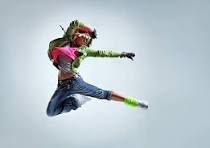

In [17]:
image_path = "img.jpg"
image = Image.open((image_path))
image

In [18]:
# NLTK -> Natutal Language Toolkit
import nltk
nltk.download('punkt') # Punkt tokenizer(pre-trained model for sentence and word tokenization)
from nltk import sent_tokenize # split a text string into a list of sentence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [19]:
import locale
print(locale.getlocale()) # output -> (language_code, encoding)

('en_US', 'UTF-8')


In [20]:
max_new_tokens = 200 # maximum tokens of response to prompt

# Instruction for the model
prompt_instructions = """
Describe the image using as much detail as possible,
is it a painting, a photograph, what colors are predominant,
what is the image about?
"""

# creates a string prompt = " ", that formats the input for the model
prompt = "USER: <image>\n" + prompt_instructions + "\nASSISTANT:"

# calls the pipe function(which is likely an instance of the image-to-text pipeline) with the following arguments:
# image:actal image, prompt:user request, generate_kwargs:dic conatning generation parameters
outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

# to break generated text(which is stored in outputs[0]["generated text"]) into individual sentence
for sent in sent_tokenize(outputs[0]["generated_text"]):
    print(sent)

USER:  

Describe the image using as much detail as possible,
is it a painting, a photograph, what colors are predominant,
what is the image about?
ASSISTANT: The image features a person, likely a woman, wearing a green jacket and performing a jumping motion.
The person appears to be in mid-air, possibly doing a trick or simply enjoying the moment.
The scene is set against a white background, which adds to the overall visual impact of the image.
The person's outfit, which includes a green jacket, is the main focus of the scene, and the action of the jump adds an element of excitement and energy to the image.


In [21]:
# way to suppress earning messages in Python, leading to clear output
warnings.filterwarnings("ignore")

In [22]:
import warnings
from gtts import gTTS
import numpy as np

In [23]:
# CUDA(Compute Unified Device Architecture)
torch.cuda.is_available() # this function checks CUDA-compatible GPU is available on the system
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using torch {torch.__version__} ({DEVICE})")

Using torch 2.4.1+cu121 (cuda)


In [24]:
import whisper # OpenAI Whisper library, which provides pre-trained models for automatic speech recognition(ASR)

# load the medium version of the Whisper mode
# device = DEVICE, ensures the model is loaded on GPU ("cuda") if available, otherwise it defaults to CPU.
model = whisper.load_model("medium", device=DEVICE)
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

100%|█████████████████████████████████████| 1.42G/1.42G [00:28<00:00, 53.4MiB/s]


Model is multilingual and has 762,321,920 parameters.


In [25]:
import re # provides the regular expression(regex) module

In [27]:
input_text = 'What color is the image?'
input_image = 'img.jpg'

# load the image
image = Image.open(input_image)

# prompt_instructions = """
# Describe the image using as much detail as possible, is it a painting, a photograph, what colors are predominant, what is the image about?
# """

# print(input_text)
prompt_instructions = """
Act as an expert in imagery descriptive analysis, using as much detail as possible from the image, respond to the following prompt:
""" + input_text
prompt = "USER: <image>\n" + prompt_instructions + "\nASSISTANT:"

# print(prompt)

outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

match = re.search(r'ASSISTANT:\s*(.*)', outputs[0]["generated_text"])

if match:
    # Extract the text after "ASSISTANT:"
    extracted_text = match.group(1)
    print(extracted_text)
else:
    print("No match found.")

for sent in sent_tokenize(outputs[0]["generated_text"]):
    print(sent)

The image is in color.
USER:  

Act as an expert in imagery descriptive analysis, using as much detail as possible from the image, respond to the following prompt:
What color is the image?
ASSISTANT: The image is in color.


In [28]:
import datetime
import os

In [29]:
## Logger file
tstamp = datetime.datetime.now()
tstamp = str(tstamp).replace(' ','_')
logfile = f'{tstamp}_log.txt'
def writehistory(text):
    with open(logfile, 'a', encoding='utf-8') as f:
        f.write(text)
        f.write('\n')
    f.close()

In [30]:
import re
import requests
from PIL import Image

def img2txt(input_text, input_image):

    # load the image
    image = Image.open(input_image)

    writehistory(f"Input text: {input_text} - Type: {type(input_text)} - Dir: {dir(input_text)}")
    if type(input_text) == tuple:
        prompt_instructions = """
        Describe the image using as much detail as possible, is it a painting, a photograph, what colors are predominant, what is the image about?
        """
    else:
        prompt_instructions = """
        Act as an expert in imagery descriptive analysis, using as much detail as possible from the image, respond to the following prompt:
        """ + input_text

    writehistory(f"prompt_instructions: {prompt_instructions}")
    prompt = "USER: <image>\n" + prompt_instructions + "\nASSISTANT:"

    outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

    # Properly extract the response text
    if outputs is not None and len(outputs[0]["generated_text"]) > 0:
        match = re.search(r'ASSISTANT:\s*(.*)', outputs[0]["generated_text"])
        if match:
            # Extract the text after "ASSISTANT:"
            reply = match.group(1)
        else:
            reply = "No response found."
    else:
        reply = "No response generated."

    return reply

In [31]:
def transcribe(audio):

    # Check if the audio input is None or empty
    if audio is None or audio == '':
        return ('','',None)  # Return empty strings and None audio file

    # language = 'en'

    audio = whisper.load_audio(audio)
    audio = whisper.pad_or_trim(audio)

    mel = whisper.log_mel_spectrogram(audio).to(model.device)

    _, probs = model.detect_language(mel)
    detected_lang = max(probs, key=probs.get)
    print(detected_lang)

    options = whisper.DecodingOptions()
    result = whisper.decode(model, mel, options)
    result_text = result.text

    return result_text

In [32]:
def text_to_speech(text, file_path):
    language = 'en'

    audioobj = gTTS(text = text,
                    lang = language,
                    slow = False)

    audioobj.save(file_path)

    return file_path

In [33]:
!ffmpeg -f lavfi -i anullsrc=r=44100:cl=mono -t 10 -q:a 9 -acodec libmp3lame Temp.mp3

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
import gradio as gr
import base64
import os

# A function to handle audio and image inputs
def process_inputs(audio_path, image_path):
    # Process the audio file (assuming this is handled by a function called 'transcribe')
    speech_to_text_output = transcribe(audio_path)

    # Handle the image input
    if image_path:
        chatgpt_output = img2txt(speech_to_text_output, image_path)
    else:
        chatgpt_output = "No image provided."

    # Assuming 'transcribe' also returns the path to a processed audio file
    processed_audio_path = text_to_speech(chatgpt_output, "Temp3.mp3")  # Replace with actual path if different

    return speech_to_text_output, chatgpt_output, processed_audio_path

# Create the interface
iface = gr.Interface(
    fn=process_inputs,
    inputs=[
        gr.Audio(sources=["microphone","upload"], type="filepath"),
        gr.Image(type="filepath")
    ],
    outputs=[
        gr.Textbox(label="Speech to Text"),
        gr.Textbox(label="ChatGPT Output"),
        gr.Audio("Temp.mp3")
    ],
    title="Interactive Media Analysis: Using Whisper and LLaVA for Image and Audio Processing",
    description="Upload an image and interact via voice input and audio response."
)

# Launch the interface
iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6903b34aeea0074cf7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
